100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.7MB/s]



--- Curve Dataset ---
Step 0000 | Stage=Convex | Loss=0.00000
Step 0050 | Stage=Convex | Loss=0.00000
Step 0100 | Stage=Convex | Loss=0.00000

Switching to nonconvex refinement...

Step 0150 | Stage=Nonconvex | Loss=0.00635
Step 0200 | Stage=Nonconvex | Loss=0.00126
Step 0250 | Stage=Nonconvex | Loss=0.00016
Step 0300 | Stage=Nonconvex | Loss=0.00001
Step 0350 | Stage=Nonconvex | Loss=0.00000
Step 0400 | Stage=Nonconvex | Loss=-0.00000
Step 0450 | Stage=Nonconvex | Loss=-0.00000

--- Telecom Dataset ---
Step 0000 | Stage=Convex | Loss=0.00000
Step 0050 | Stage=Convex | Loss=0.00000
Step 0100 | Stage=Convex | Loss=0.00000

Switching to nonconvex refinement...

Step 0150 | Stage=Nonconvex | Loss=0.00634
Step 0200 | Stage=Nonconvex | Loss=0.00113
Step 0250 | Stage=Nonconvex | Loss=0.00013
Step 0300 | Stage=Nonconvex | Loss=0.00001
Step 0350 | Stage=Nonconvex | Loss=0.00000
Step 0400 | Stage=Nonconvex | Loss=-0.00000
Step 0450 | Stage=Nonconvex | Loss=-0.00000

--- Reduced MNIST Dataset -

/tmp/ipython-input-1-2508629059.py:365: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


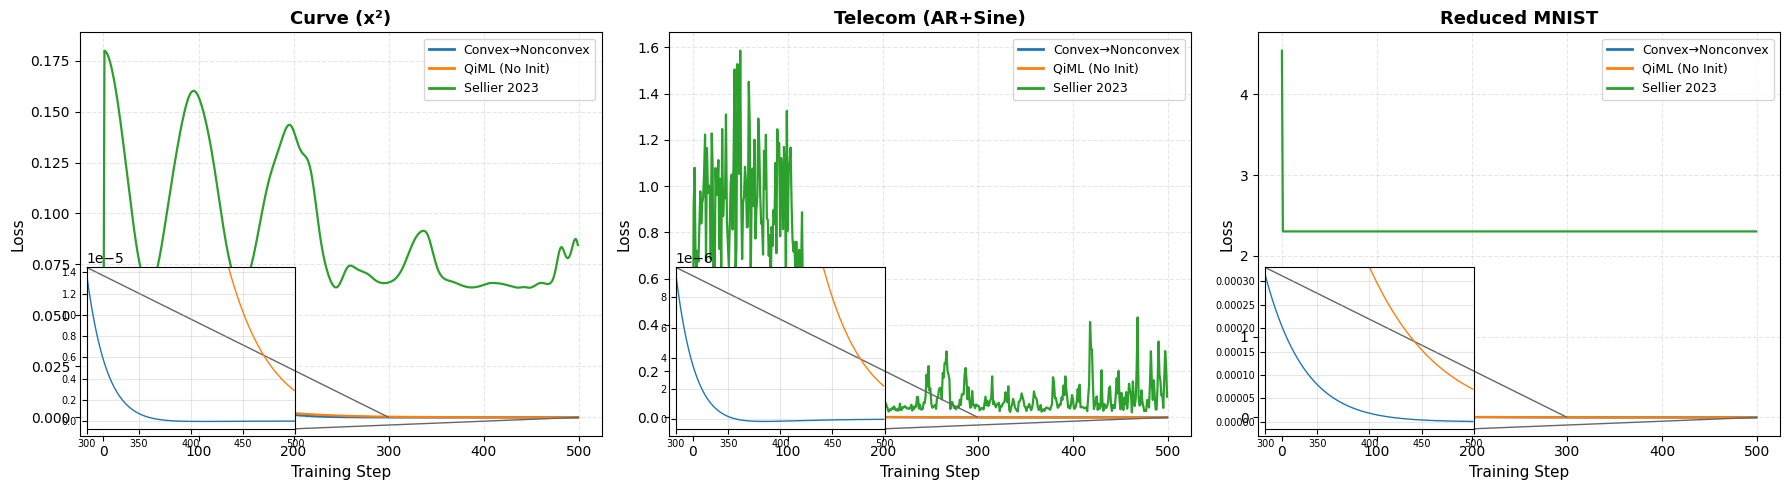

✅ Saved combined loss plot to: plots/QiML_Loss_Comparison.png


/tmp/ipython-input-1-2508629059.py:401: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


📊 Saved individual dataset plot with zoom to: plots/Curve_x².png
📊 Saved individual dataset plot with zoom to: plots/Telecom_AR+Sine.png
📊 Saved individual dataset plot with zoom to: plots/Reduced_MNIST.png


<Figure size 640x480 with 0 Axes>

In [1]:
# -*- coding: utf-8 -*-
"""
Multistage QiML: Convex → Nonconvex Refinement
Comparison with:
 - QiML (No Initialization)
 - Sellier JM. (2023)
 - Reduced MNIST (if available)

Features:
 - Single shared random initialization for fair comparison
 - Fixed DataLoader generator for identical batch order
 - Unified plotting for multiple datasets
 - Zoomed inset focusing on steps 300–500
"""

import math, os, copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from torchvision import datasets, transforms
datasets.MNIST('~/.torch/datasets', train=True, download=True, transform=transforms.ToTensor())
datasets.MNIST('~/.torch/datasets', train=False, download=True, transform=transforms.ToTensor())


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================
# Utility & Data Setup
# =====================

def seed_all(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    try:
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

def make_fixed_loader(data, batch_size=16, seed=123):
    g = torch.Generator(device='cpu').manual_seed(seed)
    return DataLoader(data, batch_size=min(len(data), batch_size), shuffle=True, generator=g)

def make_curve_dataset(func="x2"):
    xs_train = torch.tensor([0.15, 0.60, 0.80], dtype=torch.float32).unsqueeze(1)
    xs_val   = torch.tensor([0.30, 0.70], dtype=torch.float32).unsqueeze(1)
    f = (lambda x: x**2) if func == "x2" else (lambda x: torch.sqrt(x))
    ys_train, ys_val = f(xs_train), f(xs_val)
    return TensorDataset(xs_train, ys_train), TensorDataset(xs_val, ys_val)

def make_telecom_data(n_train=1024, n_val=256):
    T = n_train + n_val + 200
    t = torch.arange(T, dtype=torch.float32)
    sig = torch.sin(0.03*t) + 0.6*torch.sin(0.007*t)
    ar = torch.zeros_like(sig)
    for i in range(1, T):
        ar[i] = 0.8*ar[i-1] + 0.2*sig[i-1]
    y = sig + ar + 0.05*torch.randn_like(sig)
    win = 12
    X = torch.stack([y[i:i+win] for i in range(T-win-1)], dim=0)
    Y = y[win+1:]
    X = (X - X.mean())/X.std()
    Y = (Y - Y.mean())/Y.std()
    Xtr, Ytr = X[:n_train], Y[:n_train].unsqueeze(1)
    Xva, Yva = X[n_train:n_train+n_val], Y[n_train:n_train+n_val].unsqueeze(1)
    return TensorDataset(Xtr, Ytr), TensorDataset(Xva, Yva)

def try_load_mnist_reduced(samples_per_digit=20):
    try:
        from torchvision import datasets, transforms
    except Exception:
        return None, None
    transform = transforms.ToTensor()
    try:
        root = os.path.expanduser("~/.torch/datasets")
        train = datasets.MNIST(root=root, train=True, transform=transform, download=False)
        test  = datasets.MNIST(root=root, train=False, transform=transform, download=False)
    except Exception:
        return None, None

    idxs = []
    counts = {d: 0 for d in range(10)}
    for i, (img, label) in enumerate(train):
        d = int(label)
        if counts[d] < samples_per_digit:
            idxs.append(i)
            counts[d] += 1
        if sum(counts.values()) >= samples_per_digit * 10:
            break
    if not idxs:
        return None, None

    Xr = torch.stack([train[i][0] for i in idxs]).view(-1, 28*28)
    yr = torch.tensor([int(train[i][1]) for i in idxs], dtype=torch.long)
    Xte = torch.stack([x for (x, _) in test]).view(-1, 28*28)
    yte = torch.tensor([int(y) for (_, y) in test], dtype=torch.long)
    mu, sigma = Xr.mean(), Xr.std() + 1e-6
    Xr, Xte = (Xr - mu)/sigma, (Xte - mu)/sigma
    return TensorDataset(Xr, yr), TensorDataset(Xte, yte)

# =====================
# Models
# =====================

class MLPReg(nn.Module):
    def __init__(self, in_dim, hidden=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x): return self.net(x)

class MLPCls(nn.Module):
    def __init__(self, in_dim, hidden=128, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x): return self.net(x)

# =====================
# Initialization Helpers
# =====================

def init_xavier_tanh(m):
    """Initialize Linear layers for Tanh networks using Xavier scheme."""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def clone_state_dict(model):
    """Return a deep copy of a model’s parameters for reuse."""
    return copy.deepcopy(model.state_dict())

# =====================
# QiML Optimizer (Sellier-style)
# =====================

@dataclass
class QiMLConfig:
    L: float = 10.0
    NX: int = 512
    dt: float = 1e-2
    substeps: int = 10
    RMAX: float = 2.75
    kin_coeff: float = 0.2
    pot_coeff: float = 0.5

class QiMLOptimizer:
    def __init__(self, params, cfg: QiMLConfig):
        self.params = [p for p in params if p.requires_grad]
        self.cfg = cfg
        self.x = torch.linspace(0.0, cfg.L, cfg.NX, device=device)
        k = torch.fft.fftfreq(cfg.NX, d=(cfg.L/cfg.NX)).to(device) * 2*math.pi
        self.kin_phase = torch.exp(-1j * 0.5 * cfg.kin_coeff * (k**2) * cfg.dt)
        self.psi = [torch.exp(-0.5 * ((self.x - cfg.L/2)/(cfg.L/5))**2).to(torch.complex64) for _ in self.params]

    def _x_to_param(self, x_exp):
        return (x_exp / self.cfg.L * 2*self.cfg.RMAX - self.cfg.RMAX).item()

    def step(self, grads):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                g = grads[i]
                g_val = 0.0 if g is None else g.detach().mean().clamp(-1.0, 1.0).item()
                V = self.cfg.pot_coeff * g_val * self.x
                psi = self.psi[i]
                for _ in range(self.cfg.substeps):
                    psi = torch.exp(-1j*V*self.cfg.dt/2)*psi
                    psi_k = torch.fft.fft(psi)
                    psi_k = self.kin_phase * psi_k
                    psi = torch.fft.ifft(psi_k)
                    psi = torch.exp(-1j*V*self.cfg.dt/2)*psi
                    psi = psi / torch.linalg.norm(psi)
                prob = (psi.conj() * psi).real
                x_exp = (prob * self.x).sum() / prob.sum()
                p[...] = self._x_to_param(x_exp)
                self.psi[i] = psi

# =====================
# Loss Functions
# =====================

def convex_local_loss(expectations, targets):
    return sum((expectations[i] - targets[i])**2 for i in expectations) / len(expectations)

def oscillatory_reg(theta, alpha=0.1, omega=4.0):
    return alpha * torch.sin(omega * theta).mean()

def refine_loss(E_task, L_local, theta, lam, beta):
    return (1 - lam) * E_task + lam * L_local + beta * oscillatory_reg(theta)

# =====================
# Training Algorithms
# =====================

def train_multistage_qiml(model, data, max_steps=1500, lr=1e-3, loader_seed=123):
    """
    Stage 1: Convex surrogate pretraining
    Stage 2: Nonconvex oscillatory refinement
    """
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loader = make_fixed_loader(data, batch_size=16, seed=loader_seed)

    lam, beta = 0.9, 0.0
    switched, hist = False, []
    it = iter(loader)

    for step in range(max_steps):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(loader)
            xb, yb = next(it)
        xb, yb = xb.to(device), yb.to(device)

        if not switched:
            exp_local = {i: torch.mean(p) for i, p in enumerate(model.parameters())}
            targets = {i: torch.zeros_like(v) for i, v in exp_local.items()}
            Lc = convex_local_loss(exp_local, targets)
            opt.zero_grad(); Lc.backward(); opt.step()
            if step > 100:
                switched, beta = True, 0.05
                print("\nSwitching to nonconvex refinement...\n")
            hist.append(float(Lc.detach().cpu()))
        else:
            exp_local = {i: torch.mean(p) for i, p in enumerate(model.parameters())}
            L_local = convex_local_loss(exp_local, {i: torch.zeros_like(v) for i, v in exp_local.items()})
            E_task = sum(torch.mean(p**2) for p in model.parameters())
            lam = max(0.0, lam * 0.98); beta *= 0.99
            theta_vec = torch.nn.utils.parameters_to_vector(model.parameters())
            L = refine_loss(E_task, L_local, theta_vec, lam, beta)
            opt.zero_grad(); L.backward(); opt.step()
            hist.append(float(L.detach().cpu()))

        if step % 50 == 0:
            print(f"Step {step:04d} | Stage={'Convex' if not switched else 'Nonconvex'} | Loss={hist[-1]:.5f}")
    return model, hist

def train_qiml_no_init(model, data, steps=1500, lr=1e-3, loader_seed=123):
    """
    QiML baseline: random initialization, no convex pretraining.
    """
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loader = make_fixed_loader(data, batch_size=16, seed=loader_seed)

    lam, beta = 0.3, 0.05
    hist = []
    it = iter(loader)

    for step in range(steps):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(loader)
            xb, yb = next(it)
        xb, yb = xb.to(device), yb.to(device)

        exp_local = {i: torch.mean(p) for i, p in enumerate(model.parameters())}
        L_local = convex_local_loss(exp_local, {i: torch.zeros_like(v) for i, v in exp_local.items()})
        E_task = sum(torch.mean(p**2) for p in model.parameters())
        lam = max(0.0, lam * 0.98); beta = beta * 0.99
        theta_vec = torch.nn.utils.parameters_to_vector(model.parameters())
        L = refine_loss(E_task, L_local, theta_vec, lam, beta)
        opt.zero_grad(); L.backward(); opt.step()
        hist.append(float(L.detach().cpu()))
    return model, hist

def train_sellier_qiml(model, data, steps=1500, lr=1e-3, loader_seed=123):
    """
    Quantum-inspired optimization from Sellier JM. (2023).
    Handles regression and classification automatically.
    """
    model = model.to(device)
    opt = QiMLOptimizer(list(model.parameters()), QiMLConfig())
    loader = make_fixed_loader(data, batch_size=16, seed=loader_seed)

    hist = []
    it = iter(loader)
    for step in range(steps):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(loader)
            xb, yb = next(it)
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)

        # ✅ Choose proper loss type
        if yb.ndim == 1 or (yb.ndim == 2 and yb.shape[1] == 1 and pred.shape[1] > 1):
            loss = F.cross_entropy(pred, yb.long())
        else:
            loss = F.mse_loss(pred, yb)

        grads = torch.autograd.grad(loss, [p for p in model.parameters() if p.requires_grad],
                                    retain_graph=False, create_graph=False, allow_unused=True)
        opt.step(grads)
        hist.append(float(loss.detach().cpu()))
    return model, hist


# =====================
# Plotting Utilities
# =====================

def plot_dataset_losses(loss_dict, inset_range=(300, 1500), save_dir="plots"):
    """
    Plot loss trajectories for multiple datasets with inset zoom and save images.

    Args:
        loss_dict: dict of {dataset_name: ([histories], [labels])}
        inset_range: tuple, range of steps for inset zoom (default: (300, 1500))
        save_dir: directory to save plots (default: 'plots')
    """
    os.makedirs(save_dir, exist_ok=True)  # create save directory if not exists

    num_datasets = len(loss_dict)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 5))
    if num_datasets == 1:
        axes = [axes]

    # --- Combined Figure ---
    for ax, (dataset_name, (hists, labels)) in zip(axes, loss_dict.items()):
        for h, lbl in zip(hists, labels):
            ax.plot(h, label=lbl, linewidth=1.6)
        ax.set_title(dataset_name, fontsize=13, fontweight='bold')
        ax.set_xlabel("Training Step", fontsize=11)
        ax.set_ylabel("Loss", fontsize=11)
        ax.grid(True, linestyle="--", alpha=0.3)

        # Legend
        leg = ax.legend(fontsize=9, frameon=True, loc='upper right')
        for line in leg.get_lines():
            line.set_linewidth(2.0)

        # Inset zoom (main combined figure)
        axins = inset_axes(ax, width="40%", height="40%", loc='lower left')
        for h in hists:
            axins.plot(h, linewidth=1.0)
        lo, hi = inset_range
        max_len = min(min(len(h) for h in hists), hi)
        lo = min(lo, max_len - 2)
        hi = max_len
        yslice = hists[0][lo:hi]
        if len(yslice) > 0:
            ymin, ymax = min(yslice), max(yslice)
            pad = 0.05 * (ymax - ymin if ymax > ymin else abs(ymax))
            axins.set_xlim(lo, hi)
            axins.set_ylim(ymin - pad, ymax + pad)
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4")
        axins.tick_params(axis='both', which='major', labelsize=7)
        axins.grid(True, alpha=0.3)

    plt.tight_layout()

    combined_path = os.path.join(save_dir, "QiML_Loss_Comparison.png")
    plt.savefig(combined_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved combined loss plot to: {combined_path}")

    # --- Individual Figures with Inset ---
    for dataset_name, (hists, labels) in loss_dict.items():
        fig, ax = plt.subplots(figsize=(6, 4))
        for h, lbl in zip(hists, labels):
            ax.plot(h, label=lbl, linewidth=1.5)
        ax.set_title(f"{dataset_name} Loss Comparison", fontsize=13, fontweight='bold')
        ax.set_xlabel("Training Step", fontsize=11)
        ax.set_ylabel("Loss", fontsize=11)
        ax.grid(True, linestyle="--", alpha=0.3)
        ax.legend(fontsize=9, frameon=True, loc='upper right')

        # Inset zoom (each individual plot)
        axins = inset_axes(ax, width="40%", height="40%", loc='lower left')
        for h in hists:
            axins.plot(h, linewidth=1.0)
        lo, hi = inset_range
        max_len = min(min(len(h) for h in hists), hi)
        lo = min(lo, max_len - 2)
        hi = max_len
        yslice = hists[0][lo:hi]
        if len(yslice) > 0:
            ymin, ymax = min(yslice), max(yslice)
            pad = 0.05 * (ymax - ymin if ymax > ymin else abs(ymax))
            axins.set_xlim(lo, hi)
            axins.set_ylim(ymin - pad, ymax + pad)
        mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4")
        axins.tick_params(axis='both', which='major', labelsize=7)
        axins.grid(True, alpha=0.3)

        plt.tight_layout()

        filename = dataset_name.replace(" ", "_").replace("(", "").replace(")", "")
        save_path = os.path.join(save_dir, f"{filename}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"📊 Saved individual dataset plot with zoom to: {save_path}")


    plt.tight_layout()
    plt.show()

# =====================
# Main Experiment
# =====================

if __name__ == "__main__":
    seed_all(42)
    datasets = {}

    # (1) Curve dataset
    train_ds, _ = make_curve_dataset("x2")
    base = MLPReg(1, hidden=250)
    base.apply(init_xavier_tanh)
    base_init = clone_state_dict(base)

    print("\n--- Curve Dataset ---")
    m1 = MLPReg(1, hidden=250); m1.load_state_dict(base_init)
    m1, h1 = train_multistage_qiml(m1, train_ds, max_steps=500)
    m2 = MLPReg(1, hidden=250); m2.load_state_dict(base_init)
    m2, h2 = train_qiml_no_init(m2, train_ds, steps=500)
    m3 = MLPReg(1, hidden=250); m3.load_state_dict(base_init)
    m3, h3 = train_sellier_qiml(m3, train_ds, steps=500)
    datasets["Curve (x²)"] = ([h1, h2, h3], ["Convex→Nonconvex", "QiML (No Init)", "Sellier 2023"])

    # (2) Telecom dataset
    print("\n--- Telecom Dataset ---")
    telecom_train, _ = make_telecom_data()
    base_t = MLPReg(12, hidden=250)
    base_t.apply(init_xavier_tanh)
    base_t_init = clone_state_dict(base_t)
    t1 = MLPReg(12, hidden=250); t1.load_state_dict(base_t_init)
    t1, ht1 = train_multistage_qiml(t1, telecom_train, max_steps=500)
    t2 = MLPReg(12, hidden=250); t2.load_state_dict(base_t_init)
    t2, ht2 = train_qiml_no_init(t2, telecom_train, steps=500)
    t3 = MLPReg(12, hidden=250); t3.load_state_dict(base_t_init)
    t3, ht3 = train_sellier_qiml(t3, telecom_train, steps=500)
    datasets["Telecom (AR+Sine)"] = ([ht1, ht2, ht3], ["Convex→Nonconvex", "QiML (No Init)", "Sellier 2023"])

    # (3) Reduced MNIST dataset
print("\n--- Reduced MNIST Dataset ---")
tr_mn, _ = try_load_mnist_reduced(samples_per_digit=500)
if tr_mn is not None:
    base_m = MLPCls(28*28, 128, 10)
    base_m.apply(init_xavier_tanh)
    base_m_init = clone_state_dict(base_m)

    # Convex → Nonconvex (ours)
    n1 = MLPCls(28*28, 128, 10); n1.load_state_dict(base_m_init)
    n1, hn1 = train_multistage_qiml(n1, tr_mn, max_steps=500)

    # QiML (No Init)  ✅ NEW
    n2 = MLPCls(28*28, 128, 10); n2.load_state_dict(base_m_init)
    n2, hn2 = train_qiml_no_init(n2, tr_mn, steps=500)

    # Sellier 2023
    n3 = MLPCls(28*28, 128, 10); n3.load_state_dict(base_m_init)
    n3, hn3 = train_sellier_qiml(n3, tr_mn, steps=500)

    # Add all three to the plotting dict
    datasets["Reduced MNIST"] = (
        [hn1, hn2, hn3],
        ["Convex→Nonconvex", "QiML (No Init)", "Sellier 2023"]
    )
else:
    print("Reduced MNIST not available locally.")

    # Plot all
plot_dataset_losses(datasets, inset_range=(300, 500))


# New Section